In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [3]:
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ANSI')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [4]:
import zipfile
zip_file = "zippedData/im.db.zip"
try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("zippedData/unZippedim.db")
        print("Extracted all")
except:
    print("Invalid file")

conn = sqlite3.connect("zippedData/unZippedim.db/im.db")

Extracted all


In [5]:
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','')
movie_gross['foreign_gross'] = movie_gross["foreign_gross"].astype("float64")

movie_info['runtime'] = movie_info['runtime'].str.replace(' minutes','')
movie_info['runtime']  = movie_info['runtime'].astype("float64")
movie_info['box_office'] = movie_info['box_office'].str.replace(',','')
movie_info['box_office'] = movie_info['box_office'].astype("float64")

movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace(',','')
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace('$', '')
movie_budgets['production_budget'] = movie_budgets['production_budget'].astype("float64")
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace(',','')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace('$', '')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].astype("float64")
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace(',','')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace('$', '')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].astype("float64")

In [6]:
reviews.drop_duplicates(inplace=True)

In [7]:
reviews['rating'].unique()

array(['3/5', nan, 'C', '2/5', 'B-', '2/4', 'B', '3/4', '4/5', '4/4',
       '6/10', '1/4', '8', '2.5/4', '4/10', '2.0/5', '3/10', '7/10', 'A-',
       '5/5', 'F', '3.5/4', 'D+', '1.5/4', '3.5/5', '8/10', 'B+', '9/10',
       '2.5/5', '7.5/10', '5.5/10', 'C-', '1.5/5', '1/5', '5/10', 'C+',
       '0/5', '6', '0.5/4', 'D', '3.1/5', '3/6', '4.5/5', '0/4', '2/10',
       'D-', '7', '1/10', '3', 'A+', 'A', '4.0/4', '9.5/10', '2.5',
       '2.1/2', '6.5/10', '3.7/5', '8.4/10', '9', '1', '7.2/10', '2.2/5',
       '0.5/10', '5', '0', '2', '4.5', '7.7', '5.0/5', '8.5/10', '3.0/5',
       '0.5/5', '1.5/10', '3.0/4', '2.3/10', '4.5/10', '4/6', '3.5',
       '8.6/10', '6/8', '2.0/4', '2.7', '4.2/10', '5.8', '4', '7.1/10',
       '5/4', 'N', '3.5/10', '5.8/10', 'R', '4.0/5', '0/10', '5.0/10',
       '5.9/10', '2.4/5', '1.9/5', '4.9', '7.4/10', '1.5', '2.3/4',
       '8.8/10', '4.0/10', '2.2', '3.8/10', '6.8/10', '7.3', '7.0/10',
       '3.2', '4.2', '8.4', '5.5/5', '6.3/10', '7.6/10', '8.1/10',
  

## Approach

We will clean the ratings column, split it into two new columns "num_of_stars" and "out_of_stars", and create a third column 'rating_out_of_10' containing the quotient - a normalized percentage rating.

We will make the following modifications to the ratings column:
- We will be changing all letter "grades" to numerical scores out of 10, evenly distributed between 0 and 10.
    - Note that F+ and F- will be grouped with F.
- We will be replacing all NaN ratings, ratings out of 2, all ratings without an "out-of" denominator, and any other nonsensical ratings with '-1/1'. This will allow us to split all ratings by the '/' character before calculating ratings out of 10; upon creating the new columns we will go back and reset all '-1/1' values to NaN.

In [8]:
import numpy as np

# Change letter ratings to numerical (out of 10)
reviews['rating'].replace('F+', 'F', inplace=True)
reviews['rating'].replace('F-', 'F', inplace=True)

letter_ratings = ['A+','A','A-','B+','B','B-','C+','C','C-','D+','D','D-','F']
nums = list(np.round(np.linspace(0,10, 13), 1))
num_ratings = [f'{str(num)}/10' for num in nums]
mapping = dict(zip(letter_ratings, num_ratings))

for rating in letter_ratings:
    reviews.replace(rating, mapping[rating], inplace=True)

reviews['rating'].fillna('-1/1', inplace=True)
    
# # Remove all ratings that do not contain '/'
for rating in reviews['rating'].unique():
    if "/" not in rating:
        reviews['rating'].replace(rating, '-1/1', inplace=True)

# Remove other nonsensical ratings
reviews['rating'].replace('R', '-1/1', inplace=True)
reviews['rating'].replace('N', '-1/1', inplace=True)
reviews['rating'].replace('T', '-1/1', inplace=True)

reviews['rating'].replace('1/2', '-1/1', inplace=True)
reviews['rating'].replace('2/2', '-1/1', inplace=True)
reviews['rating'].replace('3/2', '-1/1', inplace=True)
reviews['rating'].replace('3 1/2', '-1/1', inplace=True)
reviews['rating'].replace('1-5', '-1/1', inplace=True)
reviews['rating'].replace('5/4', '-1/1', inplace=True)
reviews['rating'].replace('2.1/2', '-1/1', inplace=True)
reviews['rating'].replace('5.5/5', '-1/1', inplace=True)



In [9]:
reviews['rating'].unique()

array(['3/5', '-1/1', '5.8/10', '2/5', '4.2/10', '2/4', '3.3/10', '3/4',
       '4/5', '4/4', '6/10', '1/4', '2.5/4', '4/10', '2.0/5', '3/10',
       '7/10', '1.7/10', '5/5', '10.0/10', '3.5/4', '7.5/10', '1.5/4',
       '3.5/5', '8/10', '2.5/10', '9/10', '2.5/5', '5.5/10', '6.7/10',
       '1.5/5', '1/5', '5/10', '5.0/10', '0/5', '0.5/4', '8.3/10',
       '3.1/5', '3/6', '4.5/5', '0/4', '2/10', '9.2/10', '1/10', '0.0/10',
       '0.8/10', '4.0/4', '9.5/10', '6.5/10', '3.7/5', '8.4/10', '7.2/10',
       '2.2/5', '0.5/10', '5.0/5', '8.5/10', '3.0/5', '0.5/5', '1.5/10',
       '3.0/4', '2.3/10', '4.5/10', '4/6', '8.6/10', '6/8', '2.0/4',
       '7.1/10', '3.5/10', '4.0/5', '0/10', '5.9/10', '2.4/5', '1.9/5',
       '7.4/10', '2.3/4', '8.8/10', '4.0/10', '3.8/10', '6.8/10',
       '7.0/10', '6.3/10', '7.6/10', '8.1/10', '3.6/5', '2/6', '7.7/10',
       '8.9/10', '8.2/10', '2.6/6', '4.1/10', '6.0/10', '1.0/4', '7.9/10',
       '8.7/10', '4.3/10', '9.6/10', '9.0/10', '8.0/10', '6.2/10', '1/

In [10]:
reviews['num_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[0]))
reviews['out_of_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[1]))
reviews['rating_out_of_10'] = reviews['num_stars'] / reviews['out_of_stars'] * 10
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,It's an allegory in search of a meaning that n...,-1/1,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",-1.0,1.0,-10.0
2,3,... life lived in a bubble in financial dealin...,-1/1,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",-1.0,1.0,-10.0
3,3,Continuing along a line introduced in last yea...,-1/1,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",-1.0,1.0,-10.0
4,3,... a perverse twist on neorealism...,-1/1,fresh,NaN,0,Cinema Scope,"October 12, 2017",-1.0,1.0,-10.0


In [11]:
reviews['rating'].replace('-1/1', np.nan, inplace=True)
reviews['num_stars'].replace(-1.0, np.nan, inplace=True)
reviews['out_of_stars'].replace(1.0, np.nan, inplace=True)
reviews['rating_out_of_10'].replace(-10.0, np.nan, inplace=True)

In [12]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",NaN,NaN,NaN
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",NaN,NaN,NaN
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",NaN,NaN,NaN
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017",NaN,NaN,NaN


In [13]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54423 entries, 0 to 54431
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                54423 non-null  int64  
 1   review            48867 non-null  object 
 2   rating            40129 non-null  object 
 3   fresh             54423 non-null  object 
 4   critic            51710 non-null  object 
 5   top_critic        54423 non-null  int64  
 6   publisher         54114 non-null  object 
 7   date              54423 non-null  object 
 8   num_stars         40129 non-null  float64
 9   out_of_stars      40129 non-null  float64
 10  rating_out_of_10  40129 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 5.0+ MB


In [14]:
reviews.loc[reviews['rating'].isna() == False].head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
6,3,"Quickly grows repetitive and tiresome, meander...",5.8/10,rotten,Eric D. Snider,0,EricDSnider.com,"July 17, 2013",5.8,10.0,5.8
7,3,Cronenberg is not a director to be daunted by ...,2/5,rotten,Matt Kelemen,0,Las Vegas CityLife,"April 21, 2013",2.0,5.0,4.0
11,3,"While not one of Cronenberg's stronger films, ...",4.2/10,fresh,Emanuel Levy,0,EmanuelLevy.Com,"February 3, 2013",4.2,10.0,4.2
12,3,Robert Pattinson works mighty hard to make Cos...,2/4,rotten,Christian Toto,0,Big Hollywood,"January 15, 2013",2.0,4.0,5.0


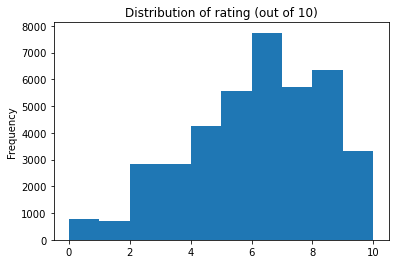

In [15]:
reviews['rating_out_of_10'].plot(kind='hist', title='Distribution of rating (out of 10)');

In [16]:
reviews['rating_out_of_10'].mean()

5.91708490119365

In [17]:
reviews['rating_out_of_10'].median()

6.0

In [18]:
reviews['rating_out_of_10'].mode()

0    6.0
dtype: float64

In [19]:
reviews.groupby('fresh')['id'].count()

fresh
fresh     33032
rotten    21391
Name: id, dtype: int64

In [20]:
imdb_join = pd.read_sql("""
SELECT * FROM movie_basics
JOIN movie_ratings
    USING(movie_id)
""", conn)
imdb_join

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,6.6,5


In [21]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010


In [22]:
imdb_movie_gross = imdb_join.merge(movie_gross, left_on='primary_title', right_on='title')
imdb_movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3027 entries, 0 to 3026
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         3027 non-null   object 
 1   primary_title    3027 non-null   object 
 2   original_title   3027 non-null   object 
 3   start_year       3027 non-null   int64  
 4   runtime_minutes  2980 non-null   float64
 5   genres           3020 non-null   object 
 6   averagerating    3027 non-null   float64
 7   numvotes         3027 non-null   int64  
 8   title            3027 non-null   object 
 9   studio           3024 non-null   object 
 10  domestic_gross   3005 non-null   float64
 11  foreign_gross    1832 non-null   float64
 12  year             3027 non-null   int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 331.1+ KB


<AxesSubplot:xlabel='numvotes'>

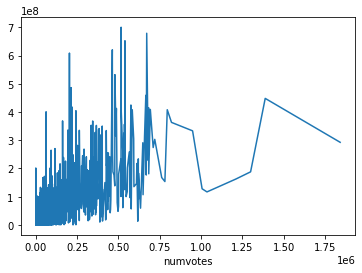

In [23]:
imdb_movie_gross.groupby('numvotes')['domestic_gross'].mean().plot()

In [24]:
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104.0,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108.0,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116.0,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128.0,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200.0,NaN


In [25]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",NaN,NaN,NaN
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",NaN,NaN,NaN
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",NaN,NaN,NaN
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017",NaN,NaN,NaN


In [26]:
rotten_tomatoes = movie_info.merge(reviews, on='id')

In [27]:
pd.read_sql("""
SELECT COUNT(DISTINCT movie_id)
FROM movie_basics
""", conn)

,COUNT(DISTINCT movie_id)
0,146144


In [28]:
imdb_movie_gross.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378,Wazir,Relbig.,1100000.0,NaN,2016
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,On the Road,IFC,744000.0,8000000.0,2012
2,tt4339118,On the Road,On the Road,2014,89.0,Drama,6.0,6,On the Road,IFC,744000.0,8000000.0,2012
3,tt5647250,On the Road,On the Road,2016,121.0,Drama,5.7,127,On the Road,IFC,744000.0,8000000.0,2012
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,The Secret Life of Walter Mitty,Fox,58200000.0,129900000.0,2013


In [29]:
imdb_movie_gross['total_gross'] = imdb_movie_gross['domestic_gross'] + imdb_movie_gross['foreign_gross']
imdb_movie_gross

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title,studio,domestic_gross,foreign_gross,year,total_gross
0,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378,Wazir,Relbig.,1100000.0,NaN,2016,NaN
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,On the Road,IFC,744000.0,8000000.0,2012,8744000.0
2,tt4339118,On the Road,On the Road,2014,89.0,Drama,6.0,6,On the Road,IFC,744000.0,8000000.0,2012,8744000.0
3,tt5647250,On the Road,On the Road,2016,121.0,Drama,5.7,127,On the Road,IFC,744000.0,8000000.0,2012,8744000.0
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,The Secret Life of Walter Mitty,Fox,58200000.0,129900000.0,2013,188100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022,tt8331988,The Chambermaid,La camarista,2018,102.0,Drama,7.1,147,The Chambermaid,FM,300.0,NaN,2015,NaN
3023,tt8404272,How Long Will I Love U,Chao shi kong tong ju,2018,101.0,Romance,6.5,607,How Long Will I Love U,WGUSA,747000.0,82100000.0,2018,82847000.0
3024,tt8427036,Helicopter Eela,Helicopter Eela,2018,135.0,Drama,5.4,673,Helicopter Eela,Eros,72000.0,NaN,2018,NaN
3025,tt9078374,Last Letter,"Ni hao, Zhihua",2018,114.0,"Drama,Romance",6.4,322,Last Letter,CL,181000.0,NaN,2018,NaN


In [30]:
rotten_tomatoes.head()

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,...,review,rating_y,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",NaN,NaN,NaN
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",NaN,NaN,NaN
3,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",NaN,NaN,NaN
4,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017",NaN,NaN,NaN


<AxesSubplot:xlabel='runtime_minutes', ylabel='total_gross'>

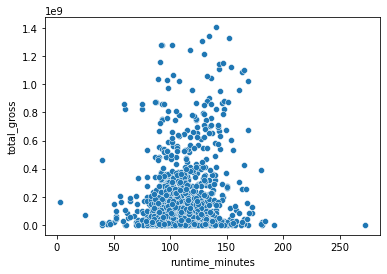

In [31]:
import seaborn as sns
sns.scatterplot(x=imdb_movie_gross['runtime_minutes'], y=imdb_movie_gross['total_gross'])

In [32]:
np.corrcoef(imdb_movie_gross.dropna(subset=['total_gross','runtime_minutes'])['runtime_minutes'], imdb_movie_gross.dropna(subset=['total_gross','runtime_minutes'])['total_gross'])

array([[1.     , 0.18881],
       [0.18881, 1.     ]])

In [33]:
imdb_movie_gross_ordered = imdb_movie_gross.sort_values(by='total_gross',ascending=False)

In [34]:
imdb_movie_gross_ordered.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title,studio,domestic_gross,foreign_gross,year,total_gross
1907,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",7.3,665594,Avengers: Age of Ultron,BV,459000000.0,946400000.0,2015,1.405400e+09
1301,tt1825683,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",7.3,516148,Black Panther,BV,700100000.0,646900000.0,2018,1.347000e+09
1984,tt2527336,Star Wars: The Last Jedi,Star Wars: Episode VIII - The Last Jedi,2017,152.0,"Action,Adventure,Fantasy",7.1,462903,Star Wars: The Last Jedi,BV,620200000.0,712400000.0,2017,1.332600e+09
2703,tt4881806,Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,2018,128.0,"Action,Adventure,Sci-Fi",6.2,219125,Jurassic World: Fallen Kingdom,Uni.,417700000.0,891800000.0,2018,1.309500e+09
459,tt1323045,Frozen,Frozen,2010,93.0,"Adventure,Drama,Sport",6.2,62311,Frozen,BV,400700000.0,875700000.0,2013,1.276400e+09


<AxesSubplot:ylabel='Frequency'>

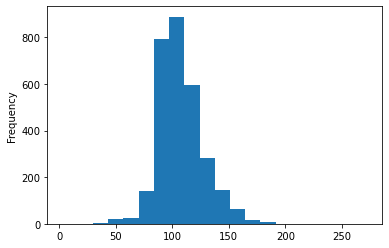

In [35]:
imdb_movie_gross['runtime_minutes'].plot(kind='hist',bins=20)

In [36]:
imdb_join['start_year'].unique()

array([2013, 2019, 2018, 2017, 2010, 2011, 2012, 2015, 2016, 2014],
      dtype=int64)

In [37]:
movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [38]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [39]:
movieJoinGross = pd.DataFrame.merge(movies, movie_gross, on = 'title')
movieJoinGross

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,studio,domestic_gross,foreign_gross,year
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,P/DW,217600000.0,277300000.0,2010
1,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Par.,312400000.0,311500000.0,2010
2,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,WB,292600000.0,535700000.0,2010
3,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,BV,415000000.0,652000000.0,2010
4,8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057,Uni.,251500000.0,291600000.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698,25090,"[16, 10751, 12]",455842,en,Elliot: The Littlest Reindeer,2.903,2018-11-30,Elliot: The Littlest Reindeer,3.4,7,Scre.,24300.0,NaN,2018
2699,25148,"[28, 12, 16]",332718,en,Bilal: A New Breed of Hero,2.707,2018-02-02,Bilal: A New Breed of Hero,6.8,54,VE,491000.0,1700000.0,2018
2700,25189,[35],498919,es,La Boda de Valentina,2.550,2018-02-09,La Boda de Valentina,6.3,7,PNT,2800000.0,NaN,2018
2701,25307,[18],470641,hi,मुक्काबाज़,2.276,2018-01-12,Mukkabaaz,7.5,18,Eros,75900.0,NaN,2018


In [40]:
rotten_tomatoes.groupby('fresh')['rating_out_of_10'].median()

fresh
fresh     7.5
rotten    5.0
Name: rating_out_of_10, dtype: float64

In [41]:
fresh_reviews = rotten_tomatoes.loc[rotten_tomatoes['fresh'] == 'fresh']
rotten_reviews = rotten_tomatoes.loc[rotten_tomatoes['fresh'] == 'rotten']

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


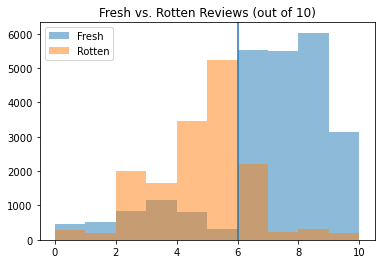

In [42]:
fig, ax = plt.subplots()
ax.hist(fresh_reviews['rating_out_of_10'], alpha=0.5)
ax.hist(rotten_reviews['rating_out_of_10'], alpha=0.5)
ax.set_title("Fresh vs. Rotten Reviews (out of 10)")
ax.legend(['Fresh','Rotten'])
plt.axvline(x=6);

In [43]:
len(fresh_reviews.loc[fresh_reviews['rating_out_of_10'] >= 6.5])/len(fresh_reviews)

0.44541656575441996

In [44]:
len(rotten_reviews.loc[rotten_reviews['rating_out_of_10'] < 6.5])/len(rotten_reviews)

0.6807535879575523

In [45]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [46]:
movie_budgets['profit'] = movie_budgets['worldwide_gross']-movie_budgets['production_budget']

In [47]:
imdb_join.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [48]:
imdb_gross = imdb_join.merge(movie_budgets, left_on='primary_title', right_on='movie')
imdb_gross.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0,-44926294.0
1,tt0326592,The Overnight,The Overnight,2010,88.0,None,7.5,24,21,"Jun 19, 2015",The Overnight,200000.0,1109808.0,1165996.0,965996.0
2,tt3844362,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,21,"Jun 19, 2015",The Overnight,200000.0,1109808.0,1165996.0,965996.0
3,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0,-15686698.0
4,tt4339118,On the Road,On the Road,2014,89.0,Drama,6.0,6,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0,-15686698.0


## Average movie rating vs. profit by director

In [49]:
directorRatings = pd.read_sql("""
    SELECT 
    persons.primary_name AS director, movie_basics.original_title AS title, movie_ratings.averagerating AS AVG_Movie_rating
    FROM persons
    JOIN principals
        USING(person_id)
    JOIN movie_basics
        USING(movie_id)
    JOIN movie_ratings
        USING(movie_id)
    GROUP BY persons.primary_name
    HAVING principals.category == 'director' AND movie_ratings.numvotes >= 1000 AND COUNT(movie_ratings.movie_id) > 1
    ORDER BY AVG_Movie_rating DESC
  ;
""", conn)

In [50]:
directorRatings.head()

,director,title,AVG_Movie_rating
0,Tim Gagliardo,Wheels,9.3
1,Murat Dündar,CM101MMXI Fundamentals,9.2
2,Dipendra K. Khanal,Pashupati Prasad,9.0
3,Tomasz Sekielski,Tylko nie mów nikomu,8.9
4,Hemanth M. Rao,Godhi Banna Sadharana Mykattu,8.9


In [51]:
budgetJoinDirector = movie_budgets.merge(directorRatings, left_on = 'movie', right_on='title')

In [52]:
budgetJoinDirector.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,director,title,AVG_Movie_rating
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,Rob Marshall,Pirates of the Caribbean: On Stranger Tides,6.6
1,14,"Mar 9, 2012",John Carter,275000000.0,73058679.0,2.827781e+08,7.778100e+06,Andrew Stanton,John Carter,6.6
2,15,"Nov 24, 2010",Tangled,260000000.0,200821936.0,5.864772e+08,3.264772e+08,Byron Howard,Tangled,7.8
3,19,"Dec 14, 2012",The Hobbit: An Unexpected Journey,250000000.0,303003568.0,1.017004e+09,7.670036e+08,Peter Jackson,The Hobbit: An Unexpected Journey,7.9
4,27,"May 4, 2012",The Avengers,225000000.0,623279547.0,1.517936e+09,1.292936e+09,Joss Whedon,The Avengers,8.1


In [53]:
budgetJoinDirector['year'] = budgetJoinDirector['release_date'].map(lambda x : x[-4:]).astype(int)
budgetJoinDirector.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,director,title,AVG_Movie_rating,year
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,Rob Marshall,Pirates of the Caribbean: On Stranger Tides,6.6,2011
1,14,"Mar 9, 2012",John Carter,275000000.0,73058679.0,2.827781e+08,7.778100e+06,Andrew Stanton,John Carter,6.6,2012
2,15,"Nov 24, 2010",Tangled,260000000.0,200821936.0,5.864772e+08,3.264772e+08,Byron Howard,Tangled,7.8,2010
3,19,"Dec 14, 2012",The Hobbit: An Unexpected Journey,250000000.0,303003568.0,1.017004e+09,7.670036e+08,Peter Jackson,The Hobbit: An Unexpected Journey,7.9,2012
4,27,"May 4, 2012",The Avengers,225000000.0,623279547.0,1.517936e+09,1.292936e+09,Joss Whedon,The Avengers,8.1,2012


In [54]:
budgetJoinDirector = budgetJoinDirector.loc[(budgetJoinDirector['year'] >= 2010) & (budgetJoinDirector['year'] <= 2017)]

In [55]:
budgetJoinDirector['year'].unique()

array([2011, 2012, 2010, 2015, 2013, 2016, 2014, 2017])

In [56]:
budgetJoinDirector.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519 entries, 0 to 571
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 519 non-null    int64  
 1   release_date       519 non-null    object 
 2   movie              519 non-null    object 
 3   production_budget  519 non-null    float64
 4   domestic_gross     519 non-null    float64
 5   worldwide_gross    519 non-null    float64
 6   profit             519 non-null    float64
 7   director           519 non-null    object 
 8   title              519 non-null    object 
 9   AVG_Movie_rating   519 non-null    float64
 10  year               519 non-null    int32  
dtypes: float64(5), int32(1), int64(1), object(4)
memory usage: 46.6+ KB


In [57]:
i = 0
for row in budgetJoinDirector.itertuples(index = False):
    if row[10] == 2010:
        budgetJoinDirector.iat[i,3] = row[3] * ((8*.0151) + 1)
       
    if row[10] == 2011:
        budgetJoinDirector.iat[i,3] = row[3] * ((7*.0151) + 1)
        
    if row[10] == 2012:
        budgetJoinDirector.iat[i,3] = row[3] * ((6*.0151) + 1)
       
    if row[10] == 2013:
        budgetJoinDirector.iat[i,3] = row[3] * ((5*.0151) + 1)
        
    if row[10] == 2014:
        budgetJoinDirector.iat[i,3] = row[3] * ((4*.0151) + 1)
        
    if row[10] == 2015:
        budgetJoinDirector.iat[i,3] = row[3] * ((3*.0151) + 1)
        
    if row[10] == 2016:
        budgetJoinDirector.iat[i,3] = row[3] * ((2*.0151) + 1)
        
    if row[10] == 2017:
        budgetJoinDirector.iat[i,3] = row[3] * ((1*.0151) + 1)
       
    i +=1
    

In [58]:
i = 0
for row in budgetJoinDirector.itertuples(index = False):
    if row[10] == 2010:
        budgetJoinDirector.iat[i,5] = row[5] * ((8*.0451) + 1)
       
    if row[10] == 2011:
        budgetJoinDirector.iat[i,5] = row[5] * ((7*.0451) + 1)
        
    if row[10] == 2012:
        budgetJoinDirector.iat[i,5] = row[5] * ((6*.0451) + 1)
       
    if row[10] == 2013:
        budgetJoinDirector.iat[i,5] = row[5] * ((5*.0451) + 1)
        
    if row[10] == 2014:
        budgetJoinDirector.iat[i,5] = row[5] * ((4*.0451) + 1)
        
    if row[10] == 2015:
        budgetJoinDirector.iat[i,5] = row[5] * ((3*.0451) + 1)
        
    if row[10] == 2016:
        budgetJoinDirector.iat[i,5] = row[5] * ((2*.0451) + 1)
        
    if row[10] == 2017:
        budgetJoinDirector.iat[i,5] = row[5] * ((1*.0451) + 1)
       
    i +=1

In [59]:
budgetJoinDirector=budgetJoinDirector.drop('id', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('release_date', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('title', axis =1)


In [60]:
budgetJoinDirector['profit'] = budgetJoinDirector['worldwide_gross']-budgetJoinDirector['production_budget']

In [61]:
budgetJoinDirector.groupby('director').mean().sort_values('AVG_Movie_rating', ascending = False)

,production_budget,domestic_gross,worldwide_gross,profit,AVG_Movie_rating,year
director,,,,,,
Denis Villeneuve,7621440.0,6857096.0,2.182498e+07,1.420354e+07,8.3,2010.0
Lee Unkrich,224160000.0,415004880.0,1.454531e+09,1.230371e+09,8.3,2010.0
Asghar Farhadi,884560.0,7098492.0,3.213751e+07,3.125295e+07,8.3,2011.0
Charles Ferguson,2241600.0,4311834.0,1.061323e+07,8.371629e+06,8.3,2010.0
Sadyk Sher-Niyaz,1484560.0,0.0,0.000000e+00,-1.484560e+06,8.3,2014.0
...,...,...,...,...,...,...
Tom Brady,11057000.0,2529395.0,3.327925e+06,-7.729075e+06,3.3,2011.0
Dennis Dugan,87350300.0,74158157.0,1.980381e+08,1.106878e+08,3.3,2011.0
Gabriela Tagliavini,5196790.0,0.0,0.000000e+00,-5.196790e+06,3.3,2011.0


In [62]:
budgetJoinDirector['positive_review'] = budgetJoinDirector['AVG_Movie_rating'] >= 6

In [63]:
grouped = budgetJoinDirector.groupby('director').mean().sort_values('AVG_Movie_rating', ascending = False)

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AVG_Movie_rating', ylabel='profit'>

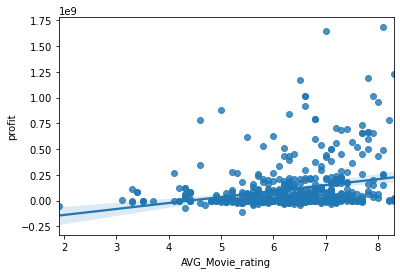

In [64]:
sns.regplot(grouped['AVG_Movie_rating'], grouped["profit"])


In [65]:
np.corrcoef(grouped['AVG_Movie_rating'], grouped['profit'])

array([[1.        , 0.25666962],
       [0.25666962, 1.        ]])

In [66]:
greaterThan6 = grouped.loc[grouped['AVG_Movie_rating'] >= 6]['profit']

In [67]:
lessThan6 = grouped.loc[grouped['AVG_Movie_rating'] < 6]['profit']

In [68]:
print(len(greaterThan6))
print(len(lessThan6))

363
155


In [69]:
greaterThan6.mean()

140185621.4822854

In [70]:
lessThan6.mean()

53195220.23562839

In [71]:
greaterThan6.median()

38740613.7528

In [72]:
lessThan6.median()

9478269.835500004

In [73]:
greaterThan6.std()

252481955.2127092

In [74]:
lessThan6.std()

129676142.28352153

In [75]:
import scipy.stats as stats
stats.ttest_ind(greaterThan6, lessThan6)

Ttest_indResult(statistic=4.0650923643709405, pvalue=5.5504521550006466e-05)

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='profit'>

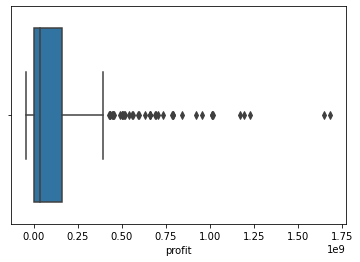

In [76]:
sns.boxplot(greaterThan6)

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='profit'>

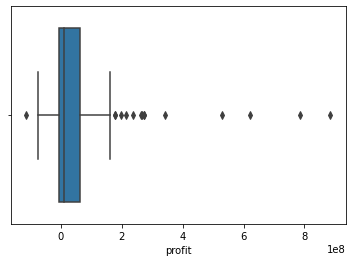

In [77]:
sns.boxplot(lessThan6)

## Average movie rating vs. profit by director - Trimmed
We observe that there are several outliers in the grouped data above. We will use IQR to remove outliers and conduct our analysis on more typical profits.

In [78]:
Q1 = grouped['profit'].quantile(0.25)
Q3 = grouped['profit'].quantile(0.75)
IQR = Q3-Q1
grouped_trimmed = grouped.loc[(grouped['profit'] >= Q1-1.5*IQR) & (grouped['profit'] <= Q3 + 1.5*IQR)]

In [79]:
len(grouped_trimmed)

462

In [80]:
greaterThan6_trimmed = grouped_trimmed.loc[grouped_trimmed['AVG_Movie_rating'] >= 6]['profit']
lessThan6_trimmed = grouped_trimmed.loc[grouped_trimmed['AVG_Movie_rating'] < 6]['profit']

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


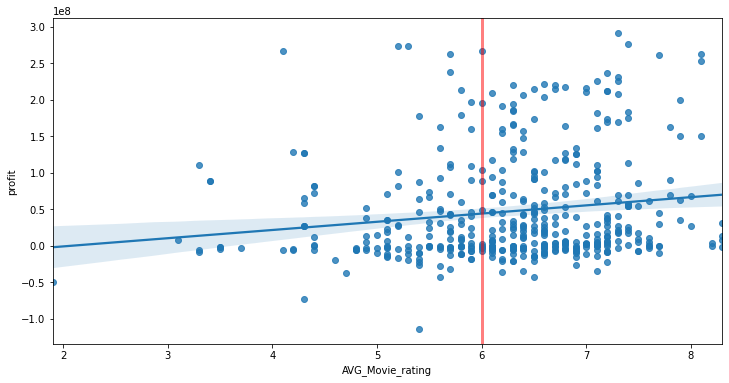

In [81]:
plt.figure(figsize=(12,6))
g = sns.regplot(grouped_trimmed['AVG_Movie_rating'], grouped_trimmed["profit"])
g.axvline(6, color='red', lw=3, alpha=0.5)

In [82]:
np.corrcoef(grouped_trimmed['AVG_Movie_rating'], grouped_trimmed['profit'])

array([[1.        , 0.15409806],
       [0.15409806, 1.        ]])

In [83]:
greaterThan6_trimmed.mean()

53967144.19823591

In [84]:
lessThan6_trimmed.mean()

33865255.457411334

In [85]:
greaterThan6_trimmed.median()

23566010.3478

In [86]:
lessThan6_trimmed.median()

8197293.544000002

In [87]:
greaterThan6_trimmed.std()**2

5460273871546999.0

In [88]:
lessThan6_trimmed.std()**2

4499248782945704.5

We observe that there is a slight positive correlation between average movie rating per director and profit. We also note that the means of these two categories differ.

Using a 5% level of significance, we will conduct a one-tailed unpaired t-test to evaluate whether directors with an average rating of greater than or equal to 6 produce greater average profits than those with an average rating of less than 6.

In [94]:
statistic, pvalue = stats.ttest_ind(greaterThan6_trimmed, lessThan6_trimmed, equal_var=False)
pvalue/2

0.0018926327845851156

Given this p-value and using a 5% level of significance, we conclude that directors with an average rating of greater than or equal to 6 produce greater average profits than those with an average rating of less than 6.